In [2]:
import cv2
import os
import csv
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda 
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam 
from keras.regularizers import l2
import keras.backend as K
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


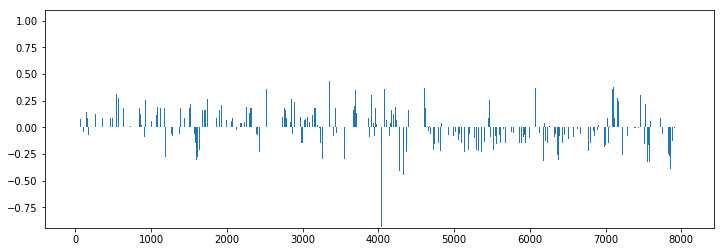

In [3]:
PATH='data/driving_log.csv'
with open(PATH) as driving_log_file:
    driving_log_reader = csv.DictReader(driving_log_file)
    steering_angles = [float(row['steering']) for row in driving_log_reader]
    plt.figure(figsize=(12,4))
    plt.bar(range(len(steering_angles)), steering_angles)
    plt.show()
    




In [5]:
column_names = ['center','left','right','steering','throttle','brake','speed']
data_df = pd.read_csv(PATH, names =column_names)
data_df.iloc[:10]

,center,left,right,steering,throttle,brake,speed
0,center,left,right,steering,throttle,brake,speed
1,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0,0,0,22.14829
2,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0,0,0,21.87963
3,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0,0,0,1.453011
4,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0,0,0,1.438419
5,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0,0,0,1.418236
6,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0,0,0,1.403993
7,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0,0,0,1.389892
8,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0,0,0,1.375934
9,IMG/center_2016_12_01_13_31_13_584.jpg,IMG/left_2016_12_01_13_31_13_584.jpg,IMG/right_2016_12_01_13_31_13_584.jpg,0,0,0,1.362115


In [13]:
data_df['steering'].describe()

count     8037
unique     125
top          0
freq      4361
Name: steering, dtype: object

In [15]:
data_df['brake'].value_counts()

 0             8003
 1                5
 0.4140807        3
 0.3269387        3
 0.3947159        2
 0.2688441        2
 0.4334456        2
 0.5109052        1
 0.6174121        1
 0.3366212        1
 0.9853449        1
 0.2204319        1
 0.7723312        1
brake             1
 0.375351         1
 0.02678302       1
 0.8110609        1
 0.03646546       1
 0.1913846        1
 0.07519523       1
 0.8207434        1
 0.0461479        1
 0.1429723        1
 0.4431281        1
Name: brake, dtype: int64

In [5]:
def get_nvidia_model(summary=True):
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0-0.5,input_shape=(66,220,3)))
    model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(36,5,5, subsample=(2,2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(48,5,5, subsample=(2,2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dropout(0.2))
    model.add(Dense(50, W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dropout(0.2))
    model.add(Dense(10, W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Dense(1))
    if summary:
        model.summary()
    return model
model = get_nvidia_model(summary=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 220, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 108, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 31, 108, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 52, 36)    21636       elu_1[0][0]                      
___________________________________________________________________________________________

In [6]:
def comma_ai_model(summary=True):
    ch, row, col = 3, 160, 320
    model = Sequential()
    model.add(Lambda(lambda x : x/255.0-0.5, input_shape=(row,col,ch)))
    model.add(Convolution2D(16,8,8, subsample=(4,4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32,5,5, subsample=(2,2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64,5,5, subsample=(2,2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
    if summary:
        model.summary()
    return model
model = comma_ai_model(summary=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 40, 80, 16)    3088        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_10 (ELU)                     (None, 40, 80, 16)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 20, 40, 32)    12832       elu_10[0][0]                     
___________________________________________________________________________________________